# Recommendation System Project based on MovieLens Data.
**Authors:** Elena Burlando


## Overview

For this project we will be analizing MovieLens data in order to develop a better performing recommendation system that will generate Top-N recommended movies to a client. 

The objective: 
 * to develop a Top-N movie recommendations for existing clients with an improved Cumulative Hit Rate (to ~ 0.05) for ratings >= 4.0.  

## Business Problem

A movie streaming company is looking to fine-tune its recommendation system. After a recent survey and a followed up research it is finding that its current recommendation system is too overwhelming to clients and presents too many options (Top-N = 100) with some that are clearly irrelevant. Low engagement is also indicated by a low Hit Rate (0.01) of top recommenders. 

One of the main pain points for this project is a lack of active environment (a website) to perform A/B testing which would be the ultimate test for a new system. 
The second pain point is the lack of implicit data such as munites watched, clicks, browsing history, etc. 


### Data Understanding 

* [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)

The dataset 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018. 

**Data is broken down into four datasets**: 
 * links: 'movieId', 'imdbId', 'tmdbId'
 * movies: 'movieId', 'title', 'genres' 
 * ratings: 'userId',  'movieId', 'rating', 'timestamp' 
 * tags: 'userId', 'movieId', 'tag', 'timestamp' 
 
***
* The target variable is rating.  
* The main metric is Cumulative Hit Rate. Other metrics that wil be used are listed below.  
* We intend to use Surprise library to test and develop a new Recommendation system.  
* For hyper parameter tuning we will use GridSearchCV and RandomizedSearchCV. 
* We will be following CRISP-DM process for this project. 
***

**Metrics**:\
\
**RMSE:**      Root Mean Squared Error. Lower values mean better accuracy.\
**MAE:**       Mean Absolute Error. Lower values mean better accuracy.\
**HR:**       Hit Rate; how often we are able to recommend a left-out rating. Higher is better.\
**cHR:**       Cumulative Hit Rate; hit rate, confined to ratings above a certain threshold. Higher is better.\
**ARHR:**      Average Reciprocal Hit Rank - Hit rate that takes the ranking into account. Higher is better.\
**Coverage:**  Ratio of users for whom recommendations above a certain threshold exist. Higher is better.\
**Diversity:** 1-S, where S is the average similarity score between every possible pair of recommendations for a given            user. Higher means more diverse.\
**Novelty:**   Average popularity rank of recommended items. Higher means more novel.

Above metrics and coding associated with it came from Frank Kane's ['Building Recommender Systems with Machine Learning and AI' course](https://www.linkedin.com/learning/building-recommender-systems-with-machine-learning-and-ai/)

***

In [1]:
# import libraries

import pandas as pd
import numpy as np
import datetime as dt

In [2]:
# links dataset

links = pd.read_csv('ml-latest-small/links.csv')
print(links.shape)
print(links.info())
links.head()


(9742, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB
None


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [3]:
# movies dataset

movies = pd.read_csv('ml-latest-small/movies.csv')
print(movies.shape)
print(movies.info())
movies.head()

(9742, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# ratings dataset

ratings_df = pd.read_csv('ml-latest-small/ratings.csv')
print(ratings_df.shape)
print(ratings_df.info())
ratings_df.head()

(100836, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
# tags dataset

tags = pd.read_csv('ml-latest-small/tags.csv')
print(tags.shape)
print(tags.info())
tags.head(30)

(3683, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB
None


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
5,2,89774,Tom Hardy,1445715205
6,2,106782,drugs,1445715054
7,2,106782,Leonardo DiCaprio,1445715051
8,2,106782,Martin Scorsese,1445715056
9,7,48516,way too long,1169687325


In [6]:
stats = ratings_df[['rating', 'timestamp']].describe()
stats

,rating,timestamp
count,100836.000000,1.008360e+05
mean,3.501557,1.205946e+09
std,1.042529,2.162610e+08
min,0.500000,8.281246e+08
25%,3.000000,1.019124e+09
50%,3.500000,1.186087e+09
75%,4.000000,1.435994e+09
max,5.000000,1.537799e+09


In [7]:
print(dt.datetime.fromtimestamp(stats.loc['min', 'timestamp']))
print(dt.datetime.fromtimestamp(stats.loc['max', 'timestamp']))

1996-03-29 10:36:55
2018-09-24 07:27:30


## EDA 

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt

In [69]:
rating_movie_df = pd.merge(ratings_df, movies, on = 'movieId', how = 'inner')
rating_movie_df

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller


In [57]:
# Ratings distribution

rating_dist = ratings_df['rating'].value_counts().sort_index(ascending=False)

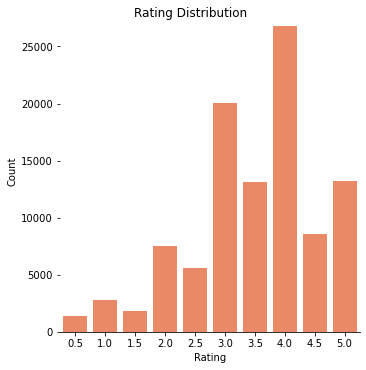

In [153]:
# Creating a bar plot
ax = sns.catplot(data = ratings_df,
                kind = 'count',
                x = 'rating', 
                color = 'coral'
               )

ax.despine(left=True)
ax.set_axis_labels('Rating', 'Count')
ax.fig.suptitle('Rating Distribution')
ax.savefig('Visuals/Rating_Distribution.png', bbox_inches='tight', dpi=600);

In [71]:
# Ratings distribution by movie
rating_dist_movie = rating_movie_df.groupby('title')['rating'].count()

In [72]:
rating_dist_movie

title
'71 (2014)                                    1
'Hellboy': The Seeds of Creation (2004)       1
'Round Midnight (1986)                        2
'Salem's Lot (2004)                           1
'Til There Was You (1997)                     2
                                             ..
eXistenZ (1999)                              22
xXx (2002)                                   24
xXx: State of the Union (2005)                5
¡Three Amigos! (1986)                        26
À nous la liberté (Freedom for Us) (1931)     1
Name: rating, Length: 9719, dtype: int64

In [161]:
top_20_movies = rating_dist_movie.reset_index().sort_values('rating', ascending = False)[:20]
top_20_movies

,title,rating
3158,Forrest Gump (1994),329
7593,"Shawshank Redemption, The (1994)",317
6865,Pulp Fiction (1994),307
7680,"Silence of the Lambs, The (1991)",279
5512,"Matrix, The (1999)",278
8001,Star Wars: Episode IV - A New Hope (1977),251
4662,Jurassic Park (1993),238
1337,Braveheart (1995),237
8363,Terminator 2: Judgment Day (1991),224
7421,Schindler's List (1993),220


/Users/elenaburlando/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


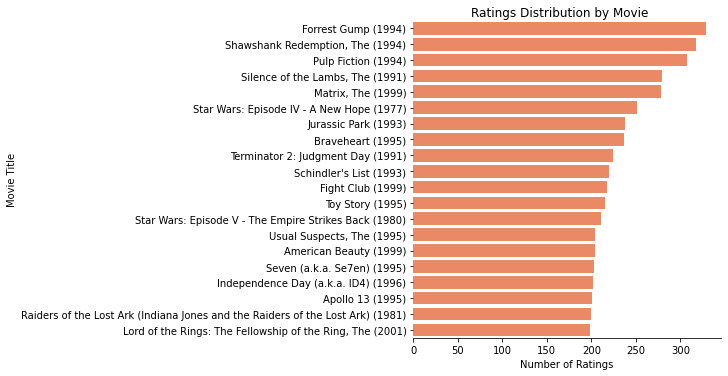

In [167]:
# Creating a bar plot
ax = sns.catplot(data = top_20_movies,
                 kind = 'bar',
                 x = 'rating',
                 y = 'title', 
                 color = 'coral'
                )

ax.despine(left=True)
ax.set_axis_labels('Number of Ratings', 'Movie Title')
ax.fig.suptitle('Ratings Distribution by Movie', verticalalignment = 'center')
ax.savefig('Visuals/Ratings_dist_by_movie.png', bbox_inches='tight', dpi=600);


In [189]:
# Ratings distribution by user
rating_dist_user = ratings_df.groupby('userId')['rating'].count()

In [195]:
top_rating_users = rating_dist_user.reset_index().sort_values('rating', ascending = False)
top_rating_users[:10]

,userId,rating
413,414,2698
598,599,2478
473,474,2108
447,448,1864
273,274,1346
609,610,1302
67,68,1260
379,380,1218
605,606,1115
287,288,1055


In [154]:
# Least # of ratings per user
top_rating_users[-10:-1]

,userId,rating
146,147,20
256,257,20
405,406,20
430,431,20
277,278,20
441,442,20
568,569,20
319,320,20
575,576,20


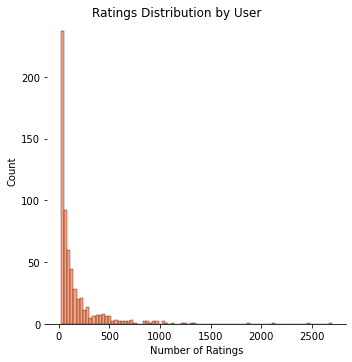

In [199]:
# Creating a bar plot
ax = sns.displot(data = top_rating_users,
                 x = 'rating', 
                 color = 'coral'
                )

ax.despine(left=True)
ax.set_axis_labels('Number of Ratings', 'Count')
ax.fig.suptitle('Ratings Distribution by User', verticalalignment = 'center')
ax.savefig('Visuals/Ratings_dist_by_user.png', bbox_inches='tight', dpi=600);


## Modeling

### Popularity-based 
- normal 
- weighted

For this project we will only do normal popularity-based filter. 


In [8]:
import os
import csv
import sys
import re

from collections import defaultdict
import numpy as np

# datasets
ratingsPath = 'ml-latest-small/ratings.csv'
moviesPath = 'ml-latest-small/movies.csv'

In [9]:
# creating Popularity-based filtering

ratings = defaultdict(int)
rankings = defaultdict(int)
with open(ratingsPath, newline='') as file:
    reader = csv.reader(file)
    next(reader)
    for row in reader:
        movieID = int(row[1])
        ratings[movieID] += 1
    rank = 1
    for movieID, ratingCount in sorted(ratings.items(), key=lambda x: x[1], reverse=True):
            rankings[movieID] = rank
            rank += 1
    print(rankings)

defaultdict(<class 'int'>, {356: 1, 318: 2, 296: 3, 593: 4, 2571: 5, 260: 6, 480: 7, 110: 8, 589: 9, 527: 10, 2959: 11, 1: 12, 1196: 13, 50: 14, 2858: 15, 47: 16, 780: 17, 150: 18, 1198: 19, 4993: 20, 1210: 21, 858: 22, 457: 23, 592: 24, 2028: 25, 5952: 26, 7153: 27, 588: 28, 608: 29, 2762: 30, 380: 31, 32: 32, 364: 33, 1270: 34, 377: 35, 3578: 36, 4306: 37, 1580: 38, 590: 39, 648: 40, 344: 41, 4226: 42, 367: 43, 58559: 44, 6539: 45, 1214: 46, 595: 47, 1036: 48, 500: 49, 165: 50, 1265: 51, 79132: 52, 1197: 53, 1704: 54, 6377: 55, 316: 56, 1291: 57, 2628: 58, 1721: 59, 153: 60, 1136: 61, 597: 62, 231: 63, 3793: 64, 293: 65, 1193: 66, 10: 67, 4886: 68, 1089: 69, 1240: 70, 6874: 71, 7361: 72, 2329: 73, 1221: 74, 34: 75, 1213: 76, 1200: 77, 1682: 78, 8961: 79, 541: 80, 736: 81, 4995: 82, 1097: 83, 5349: 84, 733: 85, 2683: 86, 1206: 87, 2716: 88, 5445: 89, 4973: 90, 1073: 91, 4963: 92, 33794: 93, 586: 94, 1527: 95, 208: 96, 587: 97, 5989: 98, 1968: 99, 185: 100, 5418: 101, 3147: 102, 349: 1

In [10]:
# Lookup a movie's name with it's Movielens ID as key
movieID_to_name = {}
with open(moviesPath, newline='', encoding='ISO-8859-1') as csvfile:
        movie_reader = csv.reader(csvfile)
        next(movie_reader)
        for row in movie_reader:
            movieID = int(row[0])
            movie_name = row[1]
            movieID_to_name[movieID] = movie_name
# Return both the dataset and lookup dict in tuple
print(movieID_to_name)

{1: 'Toy Story (1995)', 2: 'Jumanji (1995)', 3: 'Grumpier Old Men (1995)', 4: 'Waiting to Exhale (1995)', 5: 'Father of the Bride Part II (1995)', 6: 'Heat (1995)', 7: 'Sabrina (1995)', 8: 'Tom and Huck (1995)', 9: 'Sudden Death (1995)', 10: 'GoldenEye (1995)', 11: 'American President, The (1995)', 12: 'Dracula: Dead and Loving It (1995)', 13: 'Balto (1995)', 14: 'Nixon (1995)', 15: 'Cutthroat Island (1995)', 16: 'Casino (1995)', 17: 'Sense and Sensibility (1995)', 18: 'Four Rooms (1995)', 19: 'Ace Ventura: When Nature Calls (1995)', 20: 'Money Train (1995)', 21: 'Get Shorty (1995)', 22: 'Copycat (1995)', 23: 'Assassins (1995)', 24: 'Powder (1995)', 25: 'Leaving Las Vegas (1995)', 26: 'Othello (1995)', 27: 'Now and Then (1995)', 28: 'Persuasion (1995)', 29: 'City of Lost Children, The (CitÃ© des enfants perdus, La) (1995)', 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)', 31: 'Dangerous Minds (1995)', 32: 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 34: 'Babe (1995)', 36: 'D

In [11]:
# Utility function of getting a movie name for movieId
def getMovieName(movieID):
  if int(movieID) in movieID_to_name:
    return movieID_to_name[int(movieID)]
  else:
      return ""

In [12]:
# Getting Top 10 most popular movies
recommendations_pop = []
position = 0

for k, v in rankings.items():
    recommendations_pop.append(getMovieName(k))
    position += 1
    if (position > 10): break

for rec in recommendations_pop: 
    print(rec)        

Forrest Gump (1994)
Shawshank Redemption, The (1994)
Pulp Fiction (1994)
Silence of the Lambs, The (1991)
Matrix, The (1999)
Star Wars: Episode IV - A New Hope (1977)
Jurassic Park (1993)
Braveheart (1995)
Terminator 2: Judgment Day (1991)
Schindler's List (1993)
Fight Club (1999)


### Normal Predictor as Baseline Model and Framework

In [13]:
# brining in surprise library 

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from surprise import KNNBaseline

# setting up surprise dataset
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data = Dataset.load_from_file(ratingsPath, reader=reader)

In [14]:
# Define evaluation data
        
#Build a full training set for evaluating overall properties
fullTrainSet = data.build_full_trainset()
fullAntiTestSet = fullTrainSet.build_anti_testset()
        
#Build cosine similarity matrix for calculating diversity
sim_options = {'name': 'cosine', 'user_based': False}
simAlgo = KNNBaseline(sim_options=sim_options)
simAlgo.fit(fullTrainSet)
        
#Build a 75/25 train/test split for measuring accuracy
trainSet, testSet = train_test_split(data, test_size=.25, random_state=13)
  
#Build a "leave one out" train/test split for evaluating top-N recommenders
#And build an anti-test-set for building predictions
LOOCV = LeaveOneOut(n_splits=1, random_state=13)
for train, test in LOOCV.split(data):
    LOOCVTrain = train
    LOOCVTest = test
            
LOOCVAntiTestSet = LOOCVTrain.build_anti_testset()


Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [15]:
print(fullTrainSet.n_users)
print(fullTrainSet.n_items)

610
9724


In [16]:
# Evaluation algorithm function

from RecommenderMetrics import RecommenderMetrics

def evaluate(algo, algo_name):
    
    metrics = {}
    
    # Getting accuracy measures
    algo.fit(trainSet)    
    predictions = algo.test(testSet)
    
    print("\nEvaluating accuracy of model...")
    metrics['RMSE'] = accuracy.rmse(predictions)
    metrics['MAE'] = accuracy.mae(predictions)
    
    
    # Evaluate top-10 with Leave One Out testing
    print("Evaluating top-N with leave-one-out...")
    algo.fit(LOOCVTrain)
    leftOutPredictions = algo.test(LOOCVTest)        
    
    # Build predictions for all ratings not in the training set
    allPredictions = algo.test(LOOCVAntiTestSet)
    
    # Compute top 10 recs for each user
    topNPredicted = RecommenderMetrics.GetTopN(allPredictions, n=10)
    
    print("Computing hit-rate and rank metrics...")
    
    # See how often we recommended a movie the user actually rated
    metrics['HR'] = RecommenderMetrics.HitRate(topNPredicted, leftOutPredictions)   
    
    # Break down hit rate by rating value
    RecommenderMetrics.RatingHitRate(topNPredicted, leftOutPredictions)
    
    # See how often we recommended a movie the user actually liked
    metrics['cHR'] = RecommenderMetrics.CumulativeHitRate(topNPredicted, leftOutPredictions, ratingCutoff = 4.0)
    
    # Compute ARHR
    metrics['ARHR'] = RecommenderMetrics.AverageReciprocalHitRank(topNPredicted, leftOutPredictions)
        
    #Evaluate properties of recommendations on full training set
    print("Computing recommendations with full data set...")
    
    algo.fit(fullTrainSet)
    allPredictions = algo.test(fullAntiTestSet)
    topNPredicted = RecommenderMetrics.GetTopN(allPredictions, n=10)
    
    print("Analyzing coverage, diversity, and novelty...")
    # Print user coverage with a minimum predicted rating of 4.0:
    metrics["Coverage"] = RecommenderMetrics.UserCoverage(topNPredicted, fullTrainSet.n_users, 
                                                          ratingThreshold=4.0)
    # Measure diversity of recommendations:
    metrics["Diversity"] = RecommenderMetrics.Diversity(topNPredicted, simAlgo)
            
    # Measure novelty (average popularity rank of recommendations):
    metrics["Novelty"] = RecommenderMetrics.Novelty(topNPredicted, rankings)
        
    print("Analysis complete.")
    
    return metrics

In [17]:
import os
import joblib
from surprise import NormalPredictor

if 'Random.pkl' in os.listdir('Algorithms'):
    with open('Algorithms/Random.pkl', 'rb') as f: 
        Random = joblib.load(f) 
    
else:
    Random = NormalPredictor()
    
    with open('Algorithms/Random.pkl', 'wb') as f:
        joblib.dump(Random, f)
        
evaluate(Random, 'Random_algo')


Evaluating accuracy of model...
RMSE: 1.4208
MAE:  1.1345
Evaluating top-N with leave-one-out...
Computing hit-rate and rank metrics...
3.0 0.007575757575757576
4.0 0.005813953488372093
Computing recommendations with full data set...
Analyzing coverage, diversity, and novelty...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Analysis complete.


{'RMSE': 1.4207552289358376,
 'MAE': 1.134506398708196,
 'HR': 0.003278688524590164,
 'cHR': 0.00303951367781155,
 'ARHR': 0.0005327868852459017,
 'Coverage': 1.0,
 'Diversity': 0.0511051190083599,
 'Novelty': 855.2627868852459}

In [18]:
def GetAntiTestSetForUser(testSubject):
        trainset = fullTrainSet
        fill = trainset.global_mean
        anti_testset = []
        u = trainset.to_inner_uid(str(testSubject))
        user_items = set([j for (j, _) in trainset.ur[u]])
        anti_testset += [(trainset.to_raw_uid(u), trainset.to_raw_iid(i), fill) for
                                 i in trainset.all_items() if
                                 i not in user_items]
        return anti_testset



def SampleTopNRecs(algo, testSubject=85, k=10):
        
        algo.fit(fullTrainSet)
            
        print("Computing recommendations...")
        testSet = GetAntiTestSetForUser(testSubject)
        
        predictions = algo.test(testSet)
            
        recommendations = []
            
        print ("\nWe recommend:")
        for userID, movieID, actualRating, estimatedRating, _ in predictions:
            intMovieID = int(movieID)
            recommendations.append((intMovieID, estimatedRating))
            
        recommendations.sort(key=lambda x: x[1], reverse=True)
            
        for ratings in recommendations[:10]:
            print(getMovieName(ratings[0]), ratings[1])

In [114]:
# Let's find a subject matter that we can relate (meaning that it has similar movie preferences to my own)

subject_439 = ratings_df.loc[ratings_df['userId']==439]

movie_ids = subject_439['movieId']
movie_list = []
for movie in movie_ids: 
    movie_name = getMovieName(movie)
    movie_list.append(movie_name)

rating_list = []
for rating in subject_439.rating: 
    rating_list.append(rating)

movie_rating_subject_439 = {movie_list[i]: rating_list[i] for i in range(len(movie_list))}
movie_rating_subject_439

{'Braveheart (1995)': 3.5,
 'Shawshank Redemption, The (1994)': 5.0,
 'Forrest Gump (1994)': 5.0,
 "Schindler's List (1993)": 4.5,
 'Terminator 2: Judgment Day (1991)': 3.5,
 'Die Hard (1988)': 4.5,
 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)': 4.5,
 'Terminator, The (1984)': 4.0,
 'Indiana Jones and the Last Crusade (1989)': 3.0,
 'Armageddon (1998)': 2.0,
 'Saving Private Ryan (1998)': 4.0,
 "Bug's Life, A (1998)": 4.0,
 'Matrix, The (1999)': 5.0,
 'Cast Away (2000)': 4.5,
 'Lord of the Rings: The Fellowship of the Ring, The (2001)': 5.0,
 'Lord of the Rings: The Two Towers, The (2002)': 4.0,
 'Lord of the Rings: The Return of the King, The (2003)': 5.0,
 'Incredibles, The (2004)': 4.0,
 'Toy Story 3 (2010)': 4.0,
 'Samsara (2011)': 4.0,
 'Hobbit: An Unexpected Journey, The (2012)': 3.5}

In [87]:
SampleTopNRecs(Random, testSubject=439, k=10)

Computing recommendations...

We recommend:
She's the One (1996) 5
Citizen Kane (1941) 5
Full Metal Jacket (1987) 5
Duck Soup (1933) 5
Game, The (1997) 5
Lord of the Rings, The (1978) 5
Charlotte's Web (1973) 5
Psycho (1998) 5
Crocodile Dundee (1986) 5
Office Space (1999) 5


### Content-based Filtering
Based on item attributes: 
- genre
- year of release
- IMDB: ranking, director, actor, etc. 

Types: 
- cosine similarity
- time similarity (release year) 
- KNN 
- Mise en scene (based on attributes of movie trailer: color, mood, etc)

In [21]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [22]:
genre_rows = movies['genres'].map(lambda x: {c:1 for c in x.split('|')}).tolist()
genre_rows[:5]

[{'Adventure': 1, 'Animation': 1, 'Children': 1, 'Comedy': 1, 'Fantasy': 1},
 {'Adventure': 1, 'Children': 1, 'Fantasy': 1},
 {'Comedy': 1, 'Romance': 1},
 {'Comedy': 1, 'Drama': 1, 'Romance': 1},
 {'Comedy': 1}]

In [23]:
genre_df = pd.DataFrame(genre_rows).fillna(0).astype(int)
movies_processed = pd.concat(
    [movies.reset_index(drop=True), 
     genre_df.reset_index(drop=True)], 
    axis=1
)
movies_processed

,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),Drama,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
movies_processed.columns

Index(['movieId', 'title', 'genres', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller',
       'Horror', 'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX',
       'Western', 'Film-Noir', '(no genres listed)'],
      dtype='object')

In [25]:
movies_processed.loc[movies_processed['(no genres listed)']==1]

,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Horror,Mystery,Sci-Fi,War,Musical,Documentary,IMAX,Western,Film-Noir,(no genres listed)
8517,114335,La cravate (1957),(no genres listed),0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8684,122888,Ben-hur (2016),(no genres listed),0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8687,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed),0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8782,129250,Superfast! (2015),(no genres listed),0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8836,132084,Let It Be Me (1995),(no genres listed),0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8902,134861,Trevor Noah: African American (2013),(no genres listed),0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9033,141131,Guardians (2016),(no genres listed),0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9053,141866,Green Room (2015),(no genres listed),0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9070,142456,The Brand New Testament (2015),(no genres listed),0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9091,143410,Hyena Road,(no genres listed),0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


There are 34 movies without genre listed. 

In [26]:
# create similarity matrix based on genre

from sklearn.metrics.pairwise import cosine_similarity

sim_genre = movies_processed.drop(columns = ['title', 'genres', '(no genres listed)']).\
                                            set_index('movieId')
sim_genre = cosine_similarity(sim_genre)
sim_genre

array([[1.        , 0.77459667, 0.31622777, ..., 0.        , 0.31622777,
        0.4472136 ],
       [0.77459667, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.31622777, 0.        , 1.        , ..., 0.        , 0.        ,
        0.70710678],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.31622777, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.4472136 , 0.        , 0.70710678, ..., 0.        , 0.        ,
        1.        ]])

In [27]:
# checking the length of the sim_genre array
len(sim_genre)

9742

In [28]:
# building a custom content-based algorithm to measure performance based on genre similarity matrix
from surprise import AlgoBase
from surprise import PredictionImpossible

import numpy as np
import heapq
import math

class ContentKNNAlgorithm(AlgoBase):

    def __init__(self, k=40, sim_options={}):
        AlgoBase.__init__(self)
        self.k = k

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)

            
    # Compute genre distance for every movie combination as a 2x2 matrix
        self.similarities = sim_genre
    
  
    
    def estimate(self, u, i):

        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible('User and/or item is unkown.')
        
        # Build up similarity scores between this item and everything the user rated
        neighbors = []
        for rating in self.trainset.ur[u]:
            genreSimilarity = self.similarities[i,rating[0]]
            neighbors.append( (genreSimilarity, rating[1]) )
        
        # Extract the top-K most-similar ratings
        k_neighbors = heapq.nlargest(self.k, neighbors, key=lambda t: t[0])
        
        # Compute average sim score of K neighbors weighted by user ratings
        simTotal = weightedSum = 0
        for (simScore, rating) in k_neighbors:
            if (simScore > 0):
                simTotal += simScore
                weightedSum += simScore * rating
            
        if (simTotal == 0):
            raise PredictionImpossible('No neighbors')

        predictedRating = weightedSum / simTotal

        return predictedRating

In [29]:
content_KNN = ContentKNNAlgorithm()
evaluate(content_KNN, 'Content KNN')


Evaluating accuracy of model...
RMSE: 0.9709
MAE:  0.7534
Evaluating top-N with leave-one-out...
Computing hit-rate and rank metrics...
3.0 0.007575757575757576
5.0 0.008695652173913044
Computing recommendations with full data set...
Analyzing coverage, diversity, and novelty...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Analysis complete.


{'RMSE': 0.9709406947859511,
 'MAE': 0.7533717181317096,
 'HR': 0.003278688524590164,
 'cHR': 0.00303951367781155,
 'ARHR': 0.0008743169398907104,
 'Coverage': 0.8245901639344262,
 'Diversity': 0.4541663589104965,
 'Novelty': 3149.3891273247496}

In [115]:
SampleTopNRecs(content_KNN, testSubject=439, k=10)

Computing recommendations...

We recommend:
Harriet the Spy (1996) 4.5
Godzilla 2000 (Gojira ni-sen mireniamu) (1999) 4.5
My Own Private Idaho (1991) 4.5
Polish Wedding (1998) 4.5
Kill! (Kiru) (1968) 4.5
Flintstones, The (1994) 4.4461664071234575
Quicksilver (1986) 4.4461664071234575
Fearless (1993) 4.4461664071234575
Young Guns II (1990) 4.4461664071234575
King of New York (1990) 4.4461664071234575


### Collaborative Filtering

#### Memory based 
When user-item similarity matrixes are stored in memory. 

In [31]:
# import libraries

from surprise.prediction_algorithms import KNNWithMeans, KNNBasic
from surprise.model_selection import GridSearchCV


In [32]:
if 'cf_gs.pkl' in os.listdir('Algorithms'):
    with open('Algorithms/cf_gs.pkl', 'rb') as f: 
        cf_gs = joblib.load(f) 
    
else:
    sim_options = {
    "name": ["msd", "cosine", "pearson", "pearson_baseline"],
    "min_support": [3, 4, 5],
    "user_based": [False, True],
    }

    param_grid = {"sim_options": sim_options}

    cf_gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)
    cf_gs.fit(data)
    
    with open('Algorithms/cf_gs.pkl', 'wb') as f:
        joblib.dump(cf_gs, f)

print(cf_gs.best_score["rmse"])
print(cf_gs.best_params["rmse"])

0.9037514133976239
{'sim_options': {'name': 'msd', 'min_support': 3, 'user_based': True}}


In [33]:
# Display top two algorithms with the lowest RMSE
pd. set_option('display.max_colwidth', None)
pd.DataFrame(cf_gs.cv_results).sort_values('rank_test_rmse').head(2)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_sim_options
1,0.901978,0.908228,0.901048,0.903751,0.003188,1,0.687180,0.693989,0.687625,0.689598,0.003110,2,0.083710,0.00392,1.803835,0.121996,"{'sim_options': {'name': 'msd', 'min_support': 3, 'user_based': True}}","{'name': 'msd', 'min_support': 3, 'user_based': True}"
18,0.905582,0.905299,0.901804,0.904228,0.001718,2,0.685849,0.687159,0.685454,0.686154,0.000729,1,5.155764,0.05251,8.203052,0.567901,"{'sim_options': {'name': 'pearson_baseline', 'min_support': 3, 'user_based': False}}","{'name': 'pearson_baseline', 'min_support': 3, 'user_based': False}"


***
Two top performing algorithms with the lowest RMSE with the following 'sim_options': 
- {'name': 'msd', 'min_support': 3, 'user_based': True}
- {'name': 'pearson_baseline', 'min_support': 3, 'user_based': False}

We will measure additional metrics on these two algorithms. 
***

##### Item-based

In [34]:
# Looking into performance of KNNWithMeans and pearson_baseline similarity.

sim_options = {'name': 'pearson_baseline', 
              'user_based': False, 
              'min_support': 3}

cf_1 = KNNWithMeans(sim_options=sim_options)

evaluate(cf_1, 'CF KNNWithMeans Pearson_baseline')

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

Evaluating accuracy of model...
RMSE: 0.8966
MAE:  0.6800
Evaluating top-N with leave-one-out...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing hit-rate and rank metrics...
5.0 0.02608695652173913
Computing recommendations with full data set...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Analyzing coverage, diversity, and novelty...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Analysis complete.


{'RMSE': 0.8966398383199587,
 'MAE': 0.6800383987377562,
 'HR': 0.004918032786885246,
 'cHR': 0.00911854103343465,
 'ARHR': 0.0038251366120218575,
 'Coverage': 1.0,
 'Diversity': 0.8049600703877964,
 'Novelty': 4957.141475409836}

In [116]:
SampleTopNRecs(cf_1, testSubject=439, k=10)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing recommendations...

We recommend:
The Jinx: The Life and Deaths of Robert Durst (2015) 5
Galaxy of Terror (Quest) (1981) 5
Alien Contamination (1980) 5
I'm the One That I Want (2000) 5
Three Billboards Outside Ebbing, Missouri (2017) 5
Chorus Line, A (1985) 5
Hunt, The (Jagten) (2012) 5
The Man from Nowhere (2010) 5
Lesson Faust (1994) 5
Assignment, The (1997) 5


In [36]:
# ALS KNN Baseline with pearson_baseline 
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5}

sim_options = {'name': 'pearson_baseline', 
              'user_based': False, 
              'min_support': 3}

cf_2 = KNNBaseline(bsl_options=bsl_options, sim_options=sim_options)
evaluate(cf_2, 'CF_2 KNNBaseline')

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

Evaluating accuracy of model...
RMSE: 0.8643
MAE:  0.6569
Evaluating top-N with leave-one-out...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing hit-rate and rank metrics...
4.0 0.005813953488372093
5.0 0.043478260869565216
Computing recommendations with full data set...
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Analyzing coverage, diversity, and novelty...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Analysis complete.


{'RMSE': 0.8643251405266618,
 'MAE': 0.6569278136758996,
 'HR': 0.009836065573770493,
 'cHR': 0.0182370820668693,
 'ARHR': 0.004403460837887067,
 'Coverage': 0.9918032786885246,
 'Diversity': 0.5933052442060209,
 'Novelty': 3204.7195204322866}

In [117]:
SampleTopNRecs(cf_2, testSubject=439, k=10)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing recommendations...

We recommend:
Howl's Moving Castle (Hauru no ugoku shiro) (2004) 4.89886421485328
Discreet Charm of the Bourgeoisie, The (Charme discret de la bourgeoisie, Le) (1972) 4.831724959638593
Hunt, The (Jagten) (2012) 4.750433649073654
Stunt Man, The (1980) 4.745010757540975
Three Colors: Red (Trois couleurs: Rouge) (1994) 4.743010047401364
Call Me by Your Name (2017) 4.73869984060031
Local Hero (1983) 4.735969543299886
Anne of Green Gables (1985) 4.734475193878651
Best Exotic Marigold Hotel, The (2011) 4.729633067319535
Trial, The (ProcÃ¨s, Le) (1962) 4.729508999502569


##### User-based

In [38]:
# Looking into performance of KNNWithMeans and msd similarity.

sim_options = {'name': 'msd', 
              'user_based': True, 
              'min_support': 3}

cf_3 = KNNWithMeans(sim_options=sim_options)

evaluate(cf_3, 'CF KNNWithMeans MSD')

Computing the msd similarity matrix...
Done computing similarity matrix.

Evaluating accuracy of model...
RMSE: 0.8987
MAE:  0.6861
Evaluating top-N with leave-one-out...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing hit-rate and rank metrics...
5.0 0.017391304347826087
Computing recommendations with full data set...
Computing the msd similarity matrix...
Done computing similarity matrix.
Analyzing coverage, diversity, and novelty...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Analysis complete.


{'RMSE': 0.8987436259072746,
 'MAE': 0.6860878299041661,
 'HR': 0.003278688524590164,
 'cHR': 0.0060790273556231,
 'ARHR': 0.0006147540983606558,
 'Coverage': 0.9983606557377049,
 'Diversity': 0.783347559859022,
 'Novelty': 5771.718796250617}

In [118]:
SampleTopNRecs(cf_3, testSubject=439, k=10)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing recommendations...

We recommend:
Beautiful Thing (1996) 5
I'm the One That I Want (2000) 5
Under the Sand (2000) 5
The Hundred-Foot Journey (2014) 5
General, The (1926) 5
Flickering Lights (Blinkende lygter) (2000) 5
Hunger (2008) 5
Three Billboards Outside Ebbing, Missouri (2017) 5
Candleshoe (1977) 5
Oxygen (1999) 5


In [40]:
# Trying SGD

print('Using SGD')
bsl_options = {'method': 'sgd',
               'learning_rate': 0.005,
               'n_epochs': 20
               }

sim_options = {'name': 'cosine',
               'user_based': True  
               }

cf_4 = KNNBaseline(bsl_options=bsl_options, sim_options = sim_options)
evaluate(cf_4, 'CF_3 KNNBaseline')

Using SGD
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.

Evaluating accuracy of model...
RMSE: 0.8812
MAE:  0.6737
Evaluating top-N with leave-one-out...
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing hit-rate and rank metrics...
5.0 0.02608695652173913
Computing recommendations with full data set...
Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Analyzing coverage, diversity, and novelty...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Analysis complete.


{'RMSE': 0.8812027553304566,
 'MAE': 0.6736965104629048,
 'HR': 0.004918032786885246,
 'cHR': 0.00911854103343465,
 'ARHR': 0.004098360655737705,
 'Coverage': 1.0,
 'Diversity': 0.7870170461068473,
 'Novelty': 6044.315919172006}

In [119]:
SampleTopNRecs(cf_4, testSubject=439, k=10)

Estimating biases using sgd...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing recommendations...

We recommend:
The Jinx: The Life and Deaths of Robert Durst (2015) 5
Galaxy of Terror (Quest) (1981) 5
Looker (1981) 5
Android (1982) 5
Alien Contamination (1980) 5
Master of the Flying Guillotine (Du bi quan wang da po xue di zi) (1975) 5
I'm the One That I Want (2000) 5
Stanley Kubrick: A Life in Pictures (2001) 5
Visitor, The (2007) 5
Frozen River (2008) 5


### SVD

In [42]:
# importing relevant libraries
from surprise.prediction_algorithms import SVD, SVDpp


In [43]:
## Perform a gridsearch with SVD

if 'svd_gs.pkl' in os.listdir('Algorithms'):
    with open('Algorithms/svd_gs.pkl', 'rb') as f: 
        svd_gs = joblib.load(f) 
    
else:
    params = {'n_factors': [20, 50, 100], 
             'lr_all': [0.005, 0.01], 
             'n_epochs': [20, 30], 
             'reg_all': [0.02, 0.05, 0.1]}
    
    svd_gs = GridSearchCV(SVD,param_grid=params,n_jobs=-1, cv=3)
    svd_gs.fit(data)
    
    
    with open('Algorithms/svd_gs.pkl', 'wb') as f:
        joblib.dump(svd_gs, f)

print(svd_gs.best_score)
print(svd_gs.best_params)


{'rmse': 0.8637117963111177, 'mae': 0.6625288018679476}
{'rmse': {'n_factors': 100, 'lr_all': 0.01, 'n_epochs': 30, 'reg_all': 0.1}, 'mae': {'n_factors': 100, 'lr_all': 0.01, 'n_epochs': 30, 'reg_all': 0.1}}


In [44]:
svd_2 = SVD(n_factors = 100, lr_all = 0.01, n_epochs = 30, reg_all = 0.1)

evaluate(svd_2, 'SVD_2')


Evaluating accuracy of model...
RMSE: 0.8639
MAE:  0.6615
Evaluating top-N with leave-one-out...
Computing hit-rate and rank metrics...
3.5 0.018518518518518517
5.0 0.043478260869565216
Computing recommendations with full data set...
Analyzing coverage, diversity, and novelty...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Analysis complete.


{'RMSE': 0.8639390503789307,
 'MAE': 0.6614615539241103,
 'HR': 0.009836065573770493,
 'cHR': 0.015197568389057751,
 'ARHR': 0.002670439760603695,
 'Coverage': 0.9377049180327869,
 'Diversity': 0.44332409414256335,
 'Novelty': 2605.262497727686}

In [120]:
SampleTopNRecs(svd_2, testSubject=439, k=10)

Computing recommendations...

We recommend:
Guess Who's Coming to Dinner (1967) 4.657774820926931
Godfather, The (1972) 4.651168392731958
Three Billboards Outside Ebbing, Missouri (2017) 4.648508853596789
Neon Genesis Evangelion: The End of Evangelion (Shin seiki Evangelion GekijÃ´-ban: Air/Magokoro wo, kimi ni) (1997) 4.6217924864998805
Streetcar Named Desire, A (1951) 4.600690137400254
Gallipoli (1981) 4.585529704092382
All That Heaven Allows (1955) 4.580076434584391
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) 4.572278481276484
Captain Fantastic (2016) 4.571739327746215
Yojimbo (1961) 4.569895029018036


In [50]:
if 'svd_3.pkl' in os.listdir('Algorithms'):
    with open('Algorithms/svd_3.pkl', 'rb') as f: 
        svd_3 = joblib.load(f) 

else:
    svd_3 = SVD()
    with open('Algorithms/svd_3.pkl', 'wb') as f:
        joblib.dump(svd_3, f)

evaluate(svd_3, 'SVD_3')


Evaluating accuracy of model...
RMSE: 0.8807
MAE:  0.6752
Evaluating top-N with leave-one-out...
Computing hit-rate and rank metrics...
2.0 0.029411764705882353
2.5 0.045454545454545456
3.0 0.015151515151515152
3.5 0.018518518518518517
4.0 0.011627906976744186
4.5 0.047619047619047616
5.0 0.08695652173913043
Computing recommendations with full data set...
Analyzing coverage, diversity, and novelty...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Analysis complete.


{'RMSE': 0.8806750857000041,
 'MAE': 0.6751593982768432,
 'HR': 0.03114754098360656,
 'cHR': 0.0425531914893617,
 'ARHR': 0.011357012750455373,
 'Coverage': 0.9245901639344263,
 'Diversity': 0.031900319933304444,
 'Novelty': 505.7342618384401}

In [121]:
SampleTopNRecs(svd_2, testSubject=439, k=10)

Computing recommendations...

We recommend:
Guess Who's Coming to Dinner (1967) 4.745014407216442
Three Billboards Outside Ebbing, Missouri (2017) 4.720015191777461
Paths of Glory (1957) 4.6446103691319545
Streetcar Named Desire, A (1951) 4.61991819185824
Godfather, The (1972) 4.612015465383254
Secrets & Lies (1996) 4.606239144936886
Adam's Rib (1949) 4.584542526932856
Trial, The (ProcÃ¨s, Le) (1962) 4.582209866985488
Neon Genesis Evangelion: The End of Evangelion (Shin seiki Evangelion GekijÃ´-ban: Air/Magokoro wo, kimi ni) (1997) 4.577752288908924
Five Easy Pieces (1970) 4.56212527326592


#### SVD++

In [46]:
from surprise.model_selection import RandomizedSearchCV

In [47]:
## Perform a Randomsearch with SVD++

if 'svdpp_rs.pkl' in os.listdir('Algorithms'):
    with open('Algorithms/svdpp_rs.pkl', 'rb') as f: 
        svdpp_rs = joblib.load(f) 

else:
    params = {'n_factors': [20, 50, 100], 
              'lr_all': [0.005, 0.01, 0.1], 
              'n_epochs': [20, 30, 50], 
              'reg_all': [0.02, 0.05, 0.1], 
              'init_mean': [0, 1, 2, 3], 
              'init_std_dev': [0.1, 0.5, 0.7]}

    svdpp_rs = RandomizedSearchCV(SVDpp, param_distributions = params, n_jobs=-1, cv=3, random_state = 13)
    svdpp_rs.fit(data)

    with open('Algorithms/svdpp_rs.pkl', 'wb') as f:
        joblib.dump(svdpp_rs, f)
        
print(svdpp_rs.best_score)
print(svdpp_rs.best_params)

{'rmse': 0.9527117079363174, 'mae': 0.7249903295369508}
{'rmse': {'n_factors': 50, 'lr_all': 0.01, 'n_epochs': 30, 'reg_all': 0.1, 'init_mean': 0, 'init_std_dev': 0.7}, 'mae': {'n_factors': 50, 'lr_all': 0.01, 'n_epochs': 30, 'reg_all': 0.1, 'init_mean': 0, 'init_std_dev': 0.7}}


In [48]:
params = svdpp_rs.best_params['rmse']
svdpp = SVD(n_factors=params['n_factors'], lr_all=params['lr_all'], n_epochs=params['n_epochs'], \
            reg_all=params['reg_all'], init_mean = params['init_mean'], init_std_dev = params['init_std_dev'])

evaluate(svdpp, 'SVD++')


Evaluating accuracy of model...
RMSE: 0.9341
MAE:  0.7106
Evaluating top-N with leave-one-out...
Computing hit-rate and rank metrics...
4.0 0.005813953488372093
Computing recommendations with full data set...
Analyzing coverage, diversity, and novelty...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Analysis complete.


{'RMSE': 0.9341099643158288,
 'MAE': 0.7106229455600782,
 'HR': 0.001639344262295082,
 'cHR': 0.00303951367781155,
 'ARHR': 0.0003278688524590164,
 'Coverage': 0.9983606557377049,
 'Diversity': 0.5341586677110977,
 'Novelty': 3319.000494315373}

In [122]:
SampleTopNRecs(svdpp, testSubject=439, k=10)

Computing recommendations...

We recommend:
Blown Away (1994) 5
Adventures of Robin Hood, The (1938) 5
Winnie the Pooh and the Blustery Day (1968) 5
Sword in the Stone, The (1963) 5
Bedknobs and Broomsticks (1971) 5
Fantasia (1940) 5
Kiss the Girls (1997) 5
Welcome to Woop-Woop (1997) 5
All Quiet on the Western Front (1930) 5
Jungle Book, The (1967) 5


In [54]:
if 'svdpp_2.pkl' in os.listdir('Algorithms'):
    with open('Algorithms/svdpp_2.pkl', 'rb') as f: 
        svdpp_2 = joblib.load(f) 

else:
    svdpp_2 = SVDpp()
    with open('Algorithms/svdpp_2.pkl', 'wb') as f:
        joblib.dump(svdpp_2, f)

evaluate(svdpp_2, 'SVDpp_2')


Evaluating accuracy of model...
RMSE: 0.8682
MAE:  0.6641
Evaluating top-N with leave-one-out...
Computing hit-rate and rank metrics...
2.0 0.029411764705882353
2.5 0.045454545454545456
3.0 0.015151515151515152
3.5 0.018518518518518517
4.0 0.005813953488372093
4.5 0.07142857142857142
5.0 0.08695652173913043
Computing recommendations with full data set...
Analyzing coverage, diversity, and novelty...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Analysis complete.


{'RMSE': 0.8681853914083167,
 'MAE': 0.6640591715627461,
 'HR': 0.03114754098360656,
 'cHR': 0.0425531914893617,
 'ARHR': 0.013036690085870413,
 'Coverage': 0.9147540983606557,
 'Diversity': 0.07063896593707153,
 'Novelty': 875.9580485952923}

In [89]:
SampleTopNRecs(svdpp_2, testSubject=439, k=10)

Computing recommendations...

We recommend:
Streetcar Named Desire, A (1951) 4.548908044586783
12 Angry Men (1957) 4.5399802872258395
Ran (1985) 4.515392734559682
Three Billboards Outside Ebbing, Missouri (2017) 4.514355757991221
Grand Day Out with Wallace and Gromit, A (1989) 4.50861699618624
Departed, The (2006) 4.501026716157305
High Noon (1952) 4.4935906701537105
Seventh Seal, The (Sjunde inseglet, Det) (1957) 4.475112667114752
Secrets & Lies (1996) 4.46415371255078
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) 4.4632009805588275


## Conclusion 